# imports

In [84]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import base64
from IPython.display import display, HTML
import ipynbname
from pathlib import Path
from pyvis.network import Network
import json
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import random
import networkx.algorithms.isomorphism as iso
import time

def create_pyvis_graph(G, filename, title, directed=False):
    try:
        filename = str(Path(ipynbname.path().parent)) + "\\" + filename
    except:
        pass

    net = Network(height="600px", width="100%", directed=True, notebook=False, cdn_resources='in_line')
    
    net.from_nx(G)

    processed_pairs = {} 

    for edge in net.edges:
        src = edge['from']
        dst = edge['to']
        
        pair = tuple(sorted((str(src), str(dst))))
        
        count = processed_pairs.get(pair, 0)
        
        if count == 0:
            roundness = 0
        else:
            step = 0.3
            multiplier = (count + 1) // 2
            sign = 1 if count % 2 != 0 else -1
            roundness = sign * multiplier * step

        edge['smooth'] = {
            'enabled': True,
            'type': 'curvedCW',
            'roundness': roundness
        }
        
        if not directed:
            edge['arrows'] = {'to': {'enabled': False}}
        
        processed_pairs[pair] = count + 1

    options = {
        "edges": {
            "color": {
                "color": "#2B7CE9",
                "highlight": "#FF0000",
                "hover": "#FFF200"    
            },
            "selectionWidth": 3,
            "smooth": {
                "enabled": True, 
                "type": "curvedCW", 
                "roundness": 0.2
            }
        },
        "physics": {
            "enabled": True,
            "solver": "barnesHut",
            "barnesHut": {
                "gravitationalConstant": -3000,
                "centralGravity": 0.3,
                "springLength": 200,
                "springConstant": 0.04,
                "damping": 0.09,
                "avoidOverlap": 0.1
            }
        },
        "interaction": {
            "hover": True,
            "navigationButtons": True
        }
    }

    net.set_options(json.dumps(options))
    
    try:
        html_content = net.generate_html()
        with open(filename, "w", encoding="utf-8") as f:
            f.write(html_content)
        print(f"Готово: {filename}")
    except Exception as e:
        print(f"Ошибка: {e}")
        
    return filename



def show_html_file(filename):
    try:
        with open(filename, "rb") as f:
            html_content = f.read()
            
        b64_content = base64.b64encode(html_content).decode('utf-8')
        data_url = f'data:text/html;charset=utf-8;base64,{b64_content}'
        iframe = f'<iframe src="{data_url}" width="100%" height="650px" style="border: 1px solid #ddd; border-radius: 5px;"></iframe>'
        
        display(HTML(iframe))
        
    except FileNotFoundError:
        print(f"Файл {filename} не найден. Проверьте путь.")
        


# Шаг 1

## 1.1. Выбрать графлет из 3-4 вершин.

In [85]:
base_graphlet = nx.complete_graph(3)

## 1.2. Визуализировать в среде Python самоподобный граф из выбранного графлета до 5 уровня. Смежность старых ребер сохраняется.

In [86]:
def fractal_step_tracking(prev_graph, base_graph, current_edge_length, current_generation_index, anchor_node=0):
    G_new = nx.Graph()
    
    # 1. Замена вершин на копии
    for u, u_data in prev_graph.nodes(data=True):
        # Получаем уровень родительской вершины. Если нет (начало), считаем 0.
        parent_level = u_data.get('node_level', 0)
        
        for v_base in base_graph.nodes():
            new_node_id = (u, v_base)
            
            # ЛОГИКА РАЗМЕРА:
            # Если вершина базового графа - это "якорь" (0), то новая вершина 
            # топологически является той же самой старой вершиной. Она сохраняет свой старый уровень.
            # Все остальные вершины в копии - это "новые детали", они получают текущий уровень.
            if v_base == anchor_node:
                new_level = parent_level
            else:
                new_level = current_generation_index
            
            G_new.add_node(new_node_id, node_level=new_level)
        
        # Внутренние ребра копий
        for u_base, v_base in base_graph.edges():
            node1 = (u, u_base)
            node2 = (u, v_base)
            # Это самые "свежие" мелкие ребра
            G_new.add_edge(node1, node2, 
                           length=current_edge_length, 
                           level=current_generation_index)

    # 2. Восстановление связей (Мосты)
    for u, v, data in prev_graph.edges(data=True):
        existing_length = data.get('length', current_edge_length * 3)
        existing_edge_level = data.get('level', 0) # Уровень ребра для цвета
        
        u_anchor = (u, anchor_node)
        v_anchor = (v, anchor_node)
        
        G_new.add_edge(u_anchor, v_anchor, 
                       length=existing_length, 
                       level=existing_edge_level) # Сохраняем "старость" ребра

    return G_new


target_level = 4 # сколько уровней добавляем
initial_length = 800

current_graph = base_graphlet.copy()
nx.set_edge_attributes(current_graph, initial_length, 'length')
nx.set_edge_attributes(current_graph, 0, 'level')
nx.set_node_attributes(current_graph, 0, 'node_level')

current_len = initial_length
length_decay = 2.5 # Коэффициент уменьшения длины

for i in range(1, target_level + 1):
    current_len = current_len / length_decay
    # Передаем i как индекс текущего поколения
    current_graph = fractal_step_tracking(current_graph, base_graphlet, current_len, i)
    current_graph = nx.convert_node_labels_to_integers(current_graph)
    print(f"Уровень {i+1}: вершин {current_graph.number_of_nodes()}")

final_graph = current_graph

# --- 3. Настройка Визуализации (Белый фон) ---

# --- А. Настройка Узлов (Размер от возраста) ---
# Чем МЕНЬШЕ node_level (0, 1...), тем БОЛЬШЕ размер.
for n, data in final_graph.nodes(data=True):
    lvl = data.get('node_level', target_level)
    
    # Формула размера: Старые (lvl=0) большие, новые (lvl=max) маленькие
    # Пример: 25, 15, 10, 5...
    size = 20 / (lvl + 1) + 2 
    
    data['size'] = size
    
    # Цвет узлов: 
    # Старые - темные/черные (каркас), Новые - посветлее или цветные
    # Используем палитру Blues, но инвертированную
    color_norm = lvl / target_level
    rgba_node = cm.Blues(1 - color_norm * 0.6) # *0.6 чтобы не было совсем белых узлов
    data['color'] = mcolors.to_hex(rgba_node)
    
    # Обводка для контраста
    data['borderWidth'] = 1
    data['borderWidthSelected'] = 2

# --- Б. Настройка Ребер (Цвет для белого фона) ---
edge_levels = [d['level'] for u, v, d in final_graph.edges(data=True)]
max_lvl = max(edge_levels)

for u, v, data in final_graph.edges(data=True):
    lvl = data['level']
    norm = lvl / max_lvl if max_lvl > 0 else 0
    
    # Палитра 'winter' (синий -> зеленый) или 'cool' (циан -> маджента)
    # Для белого фона хорошо: Старые ребра -> Черные/Темно-синие, Новые -> Светло-голубые
    
    # Сделаем вручную интерполяцию от Темно-синего к Светло-бирюзовому
    # (0, 0, 0.5) -> (0, 0.8, 0.8)
    rgba = cm.ocean(norm * 0.8 + 0.1) 
    
    data['color'] = {
        'color': mcolors.to_hex(rgba),
        'opacity': 1.0 - (norm * 0.4) # Новые ребра чуть прозрачнее
    }
    
    # Толщина
    data['width'] = 4 / (lvl + 1) + 0.5


def create_white_fractal(G, filename):
    try:
        filename = str(Path(ipynbname.path().parent)) + "\\" + filename
    except:
        pass

    # bgcolor="#ffffff" - белый фон, font_color="black"
    net = Network(height="750px", width="100%", bgcolor="#ffffff", font_color="black", notebook=False)
    net.from_nx(G)

    options = {
        "physics": {
            "enabled": True,
            "solver": "forceAtlas2Based",
            "forceAtlas2Based": {
                "gravitationalConstant": -90, 
                "centralGravity": 0.008,
                "springLength": 100, 
                "springConstant": 0.1,
                "damping": 0.45
            },
            "stabilization": {"iterations": 800}
        },
        "nodes": {
            "shape": "dot",
            "font": {"size": 10} # Подписи (если включите) будут черными
        },
        "interaction": {
            "tooltipDelay": 200
        }
    }

    net.set_options(json.dumps(options))
    
    try:
        html_content = net.generate_html()
        with open(filename, "w", encoding="utf-8") as f:
            f.write(html_content)
        print(f"Готово: {filename}")
    except Exception as e:
        print(f"Ошибка: {e}")
        
    return filename

html_file = create_white_fractal(final_graph, "fractal_white_bg.html")
show_html_file(html_file)

Уровень 2: вершин 9
Уровень 3: вершин 27
Уровень 4: вершин 81
Уровень 5: вершин 243
Готово: c:\Projects\FU\Course_3\GRAPHS\fractal_white_bg.html


## 1.3. Представить граф в рабочем виде (матрица смежности, список ребер) для поиска подграфов.

In [87]:
adj = nx.adjacency_matrix(final_graph)
adj.toarray()

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]], shape=(243, 243))

In [88]:
final_graph.edges()

EdgeView([(0, 1), (0, 2), (0, 3), (0, 6), (0, 9), (0, 18), (0, 27), (0, 54), (0, 81), (0, 162), (1, 2), (3, 4), (3, 5), (3, 6), (4, 5), (6, 7), (6, 8), (7, 8), (9, 10), (9, 11), (9, 12), (9, 15), (9, 18), (10, 11), (12, 13), (12, 14), (12, 15), (13, 14), (15, 16), (15, 17), (16, 17), (18, 19), (18, 20), (18, 21), (18, 24), (19, 20), (21, 22), (21, 23), (21, 24), (22, 23), (24, 25), (24, 26), (25, 26), (27, 28), (27, 29), (27, 30), (27, 33), (27, 36), (27, 45), (27, 54), (28, 29), (30, 31), (30, 32), (30, 33), (31, 32), (33, 34), (33, 35), (34, 35), (36, 37), (36, 38), (36, 39), (36, 42), (36, 45), (37, 38), (39, 40), (39, 41), (39, 42), (40, 41), (42, 43), (42, 44), (43, 44), (45, 46), (45, 47), (45, 48), (45, 51), (46, 47), (48, 49), (48, 50), (48, 51), (49, 50), (51, 52), (51, 53), (52, 53), (54, 55), (54, 56), (54, 57), (54, 60), (54, 63), (54, 72), (55, 56), (57, 58), (57, 59), (57, 60), (58, 59), (60, 61), (60, 62), (61, 62), (63, 64), (63, 65), (63, 66), (63, 69), (63, 72), (64, 

# Шаг 2

## 2.1 Построить самоподобный граф с случайной процедурой ЗВЗ из всевозможных 2-3-4 вершинных графлетов до 5 уровня. Визуализировать графы на всей траектории G1, G2,...,G5.

## 2.2. Визуализировать в удобоваримом виде (чтобы были видны ребра, а не все в одну кучу), с минимальным пересечением ребер на плоскости. Ввести коэффициент подобия для уменьшения длины и толщины ребер, от первого шага и далее к 5 шагу.


In [89]:
# --- 1. Подготовка библиотеки графлетов (2-4 вершины) ---
def get_graphlet_library():
    """Возвращает список связных графлетов из 2, 3, 4 вершин."""
    library = []
    
    # 2 вершины
    library.append(nx.path_graph(2)) # P2 (он же K2)
    
    # 3 вершины
    library.append(nx.path_graph(3))     # P3 (уголок)
    library.append(nx.complete_graph(3)) # K3 (треугольник)
    
    # 4 вершины
    library.append(nx.path_graph(4))     # P4 (линия)
    library.append(nx.cycle_graph(4))    # C4 (квадрат)
    library.append(nx.star_graph(3))     # S4 (звезда, 1 центр + 3 луча)
    library.append(nx.complete_graph(4)) # K4 (тетраэдр)
    
    # "Лапка" (Pan graph) - треугольник с хвостиком (3-cycle with pendant)
    G_pan = nx.Graph()
    G_pan.add_edges_from([(0,1), (1,2), (2,0), (2,3)])
    library.append(G_pan)
    
    # Diamond graph (ромб с диагональю)
    G_diamond = nx.Graph()
    G_diamond.add_edges_from([(0,1), (1,2), (2,3), (3,0), (1,3)])
    library.append(G_diamond)
    
    return library

GRAPHLET_LIBRARY = get_graphlet_library()

# --- 2. Функция замены (ЗВЗ) с сохранением атрибутов ---
def random_substitution_step(prev_graph, next_graphlet, current_edge_length, generation_idx, anchor_node=0):
    """
    Заменяет каждую вершину prev_graph на копию next_graphlet.
    """
    G_new = nx.Graph()
    
    # Если в графлете нет вершины 0, находим первую попавшуюся для якоря
    if anchor_node not in next_graphlet.nodes():
        anchor_node = list(next_graphlet.nodes())[0]

    # 1. Замена вершин
    for u, u_data in prev_graph.nodes(data=True):
        parent_level = u_data.get('node_level', 0)
        
        for v_base in next_graphlet.nodes():
            new_node_id = (u, v_base)
            
            # Наследуем уровень (старость) вершины
            if v_base == anchor_node:
                new_level = parent_level
            else:
                new_level = generation_idx
            
            G_new.add_node(new_node_id, node_level=new_level)
            
        # Внутренние ребра нового графлета
        for u_base, v_base in next_graphlet.edges():
            node1 = (u, u_base)
            node2 = (u, v_base)
            G_new.add_edge(node1, node2, 
                           length=current_edge_length, 
                           level=generation_idx,
                           type='internal')

    # 2. Восстановление связей (Мосты между копиями)
    for u, v, data in prev_graph.edges(data=True):
        # Наследуем длину и уровень старого ребра
        existing_length = data.get('length', current_edge_length * 3)
        existing_edge_level = data.get('level', 0)
        
        u_anchor = (u, anchor_node)
        v_anchor = (v, anchor_node)
        
        G_new.add_edge(u_anchor, v_anchor, 
                       length=existing_length, 
                       level=existing_edge_level,
                       type='bridge')
        
    return G_new

# --- 3. Визуализация (стиль из предыдущего шага) ---
def visualize_step(G, step_num, info_text):
    """Применяет стили и сохраняет HTML."""
    
    # Копируем, чтобы не портить оригинал атрибутами визуализации
    G_vis = G.copy()
    
    # Настройка узлов (Размер от возраста)
    max_gen = step_num # Максимальное поколение на текущий момент
    
    for n, data in G_vis.nodes(data=True):
        lvl = data.get('node_level', max_gen)
        # Формула размера
        size = 25 / (lvl + 1) + 3
        data['size'] = size
        
        # Цвет (синяя гамма)
        color_norm = lvl / max_gen if max_gen > 0 else 0
        rgba_node = cm.Blues(1 - color_norm * 0.7)
        data['color'] = mcolors.to_hex(rgba_node)

    # Настройка ребер
    # Чтобы цвета не ломались на 1 шаге, делаем проверку
    edge_levels = [d.get('level', 0) for u, v, d in G_vis.edges(data=True)]
    if not edge_levels: max_lvl = 1
    else: max_lvl = max(edge_levels)
    if max_lvl == 0: max_lvl = 1

    for u, v, data in G_vis.edges(data=True):
        lvl = data.get('level', 0)
        norm = lvl / max_lvl
        
        # Палитра Ocean/Winter
        rgba = cm.ocean(norm * 0.8 + 0.1)
        data['color'] = {'color': mcolors.to_hex(rgba)}
        data['width'] = 5 / (lvl + 1) + 1

    # Pyvis
    filename = f"random_fractal_step_{step_num}.html"
    try:
        path = str(Path(ipynbname.path().parent)) + "\\" + filename
    except:
        path = filename

    net = Network(height="600px", width="100%", bgcolor="#ffffff", font_color="black", notebook=False)
    net.from_nx(G_vis)

    options = {
        "physics": {
            "forceAtlas2Based": {
                "gravitationalConstant": -80,
                "centralGravity": 0.01,
                "springLength": 80,
                "springConstant": 0.08,
                "damping": 0.5
            },
            "solver": "forceAtlas2Based",
            "stabilization": {"iterations": 600}
        },
        "interaction": {"navigationButtons": True}
    }
    net.set_options(json.dumps(options))
    
    net.save_graph(path)
    print(f"Сохранен: {filename} ({info_text})")
    return path

SIMILARITY_COEF = 0.4  
current_length = 1000

G_curr = random.choice(GRAPHLET_LIBRARY).copy()
nx.set_edge_attributes(G_curr, current_length, 'length')
nx.set_edge_attributes(G_curr, 0, 'level')
nx.set_node_attributes(G_curr, 0, 'node_level')

G_curr = nx.convert_node_labels_to_integers(G_curr)

print(f"Шаг 1: Базовый графлет {G_curr.number_of_nodes()} вершин.")
file_1 = visualize_step(G_curr, 1, f"Nodes: {G_curr.number_of_nodes()}")
show_html_file(file_1)

for step in range(2, 6):
    # Выбираем случайный графлет для этого уровня
    chosen_graphlet = random.choice(GRAPHLET_LIBRARY)
    
    # Уменьшаем длину ребра
    current_length = current_length * SIMILARITY_COEF
    
    # Применяем ЗВЗ
    G_curr = random_substitution_step(G_curr, chosen_graphlet, current_length, step-1)
    
    # Упрощаем метки
    G_curr = nx.convert_node_labels_to_integers(G_curr)
    
    info = f"Nodes: {G_curr.number_of_nodes()}, Added pattern: {chosen_graphlet.number_of_nodes()}-node graphlet"
    print(f"\nШаг {step}: {info}")
    
    # Визуализируем
    html_path = visualize_step(G_curr, step, info)
    show_html_file(html_path)
final_graph = G_curr
print("\nТраектория построена.")

Шаг 1: Базовый графлет 4 вершин.
Сохранен: random_fractal_step_1.html (Nodes: 4)



Шаг 2: Nodes: 12, Added pattern: 3-node graphlet
Сохранен: random_fractal_step_2.html (Nodes: 12, Added pattern: 3-node graphlet)



Шаг 3: Nodes: 48, Added pattern: 4-node graphlet
Сохранен: random_fractal_step_3.html (Nodes: 48, Added pattern: 4-node graphlet)



Шаг 4: Nodes: 144, Added pattern: 3-node graphlet
Сохранен: random_fractal_step_4.html (Nodes: 144, Added pattern: 3-node graphlet)



Шаг 5: Nodes: 576, Added pattern: 4-node graphlet
Сохранен: random_fractal_step_5.html (Nodes: 576, Added pattern: 4-node graphlet)



Траектория построена.


## 2.3. Вычислить коэффициент кластеризации полученного графа.

Анализ кластеризации для графа уровня 5
Средний коэффициент кластеризации (Average Clustering): 0.8355
Глобальная транзитивность (Transitivity): 0.5567


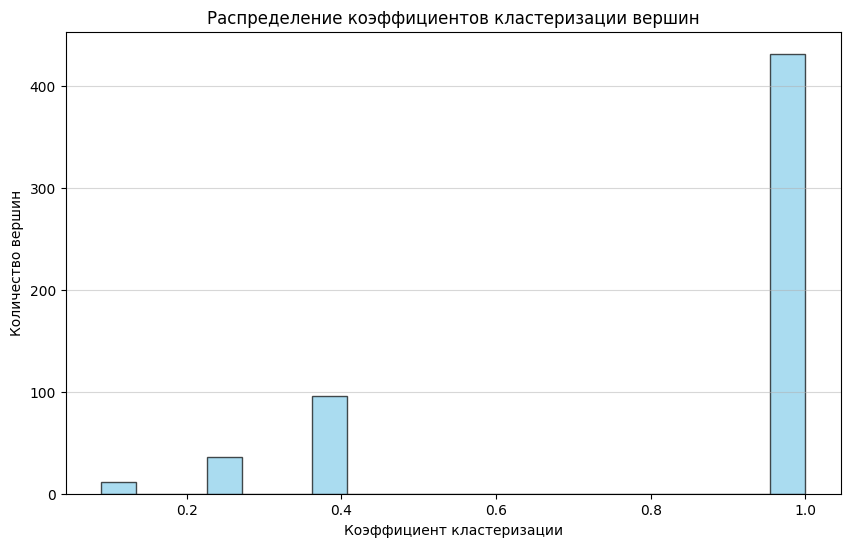

Вывод: Граф имеет выраженную кластерную структуру (много треугольников, характерно для K3, K4).


In [90]:
G_analysis = G_curr 

print(f"Анализ кластеризации для графа уровня 5")

# 1. Средний коэффициент кластеризации
# (Сумма кластеризации всех вершин / кол-во вершин)
avg_clust = nx.average_clustering(G_analysis)
print(f"Средний коэффициент кластеризации (Average Clustering): {avg_clust:.4f}")

# 2. Транзитивность (Глобальный коэффициент)
# (3 * число_треугольников / число_триад)
glob_transitivity = nx.transitivity(G_analysis)
print(f"Глобальная транзитивность (Transitivity): {glob_transitivity:.4f}")

# 3. Гистограмма распределения (Дополнительно, для красоты отчета)
# Получаем словарь {вершина: коэффициент}
clustering_dict = nx.clustering(G_analysis)
clustering_values = list(clustering_dict.values())

plt.figure(figsize=(10, 6))
plt.hist(clustering_values, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Распределение коэффициентов кластеризации вершин")
plt.xlabel("Коэффициент кластеризации")
plt.ylabel("Количество вершин")
plt.grid(axis='y', alpha=0.5)
plt.show()

# 4. Интерпретация (можно добавить в вывод)
if avg_clust == 0:
    print("Вывод: Граф не содержит треугольников (древовидная структура или циклы >3).")
elif avg_clust > 0.5:
    print("Вывод: Граф имеет выраженную кластерную структуру (много треугольников, характерно для K3, K4).")
else:
    print("Вывод: Умеренная кластеризация.")

## 2.4. Решить обратную задачу – найти графлеты 2-3-4 в построенном графе.
## 2.5. Посчитать статистику – количество разных графлетов.

In [91]:
# --- 1. Подготовка библиотеки с именами ---
# Нам нужно знать, что именно мы ищем (имена: "Треугольник", "Звезда" и т.д.)
def get_named_library():
    lib = []
    
    # --- 2 Вершины ---
    # P2 (Ребро)
    lib.append(("P2 (Edge)", nx.path_graph(2)))
    
    # --- 3 Вершины ---
    # P3 (Уголок)
    lib.append(("P3 (Path-3)", nx.path_graph(3)))
    # K3 (Треугольник)
    lib.append(("K3 (Triangle)", nx.complete_graph(3)))
    
    # --- 4 Вершины ---
    # P4 (Линия)
    lib.append(("P4 (Path-4)", nx.path_graph(4)))
    # C4 (Квадрат)
    lib.append(("C4 (Square)", nx.cycle_graph(4)))
    # S4 (Звезда / Claw)
    lib.append(("S4 (Star)", nx.star_graph(3)))
    # K4 (Тетраэдр)
    lib.append(("K4 (Tetrahedron)", nx.complete_graph(4)))
    
    # Pan (Сковородка/Лапка)
    G_pan = nx.Graph([(0,1), (1,2), (2,0), (2,3)])
    lib.append(("Pan (Paw)", G_pan))
    
    # Diamond (Ромб с перемычкой)
    G_diamond = nx.Graph([(0,1), (1,2), (2,3), (3,0), (1,3)])
    lib.append(("Diamond", G_diamond))
    
    return lib

named_library = get_named_library()
named_library

[('P2 (Edge)', <networkx.classes.graph.Graph at 0x18c081e8bf0>),
 ('P3 (Path-3)', <networkx.classes.graph.Graph at 0x18c081fc320>),
 ('K3 (Triangle)', <networkx.classes.graph.Graph at 0x18c081fe720>),
 ('P4 (Path-4)', <networkx.classes.graph.Graph at 0x18c081fcc80>),
 ('C4 (Square)', <networkx.classes.graph.Graph at 0x18c078d3230>),
 ('S4 (Star)', <networkx.classes.graph.Graph at 0x18c078d3290>),
 ('K4 (Tetrahedron)', <networkx.classes.graph.Graph at 0x18c078d3650>),
 ('Pan (Paw)', <networkx.classes.graph.Graph at 0x18c0ba65400>),
 ('Diamond', <networkx.classes.graph.Graph at 0x18c0b7bd220>)]

In [92]:

# --- 2. Функция поиска графлетов (Обратная задача) ---

def find_graphlets(target_graph, library):
    print(f"--- Запуск поиска графлетов в графе из {target_graph.number_of_nodes()} вершин ---")
    print("Это может занять время для графлетов из 4 вершин...\n")
    
    results = {}
    
    # Для ускорения переводим граф в ненаправленный (если он вдруг направленный)
    G_target = target_graph.to_undirected()
    
    for name, motif in library:
        start_time = time.time()
        
        # Инициализируем матчер (алгоритм VF2)
        # Мы ищем ИНДУЦИРОВАННЫЕ подграфы (subgraph_isomorphisms_iter)
        # Если нужны неиндуцированные (просто вхождение)
        GM = iso.GraphMatcher(G_target, motif)
        
        # GraphMatcher возвращает все перестановки (для треугольника ABC вернет ABC, BCA, CBA...)
        # Нам нужно посчитать уникальные наборы вершин.
        unique_subgraphs = set()
        
        for mapping in GM.subgraph_isomorphisms_iter():
            # mapping - это словарь {id_в_большом: id_в_малом}
            # Собираем ключи (вершины большого графа) и морозим их в set
            nodes_subset = frozenset(mapping.keys())
            unique_subgraphs.add(nodes_subset)
            
            # Ограничитель для безопасности (если граф очень большой)
            # if len(unique_subgraphs) > 10000: break 
            
        count = len(unique_subgraphs)
        elapsed = time.time() - start_time
        
        results[name] = count
        print(f"Найден графлет '{name}': {count} шт. (за {elapsed:.2f} сек)")
        
    return results

# --- 3. Запуск анализа ---
graphlet_counts = find_graphlets(final_graph, named_library)
graphlet_counts

--- Запуск поиска графлетов в графе из 576 вершин ---
Это может занять время для графлетов из 4 вершин...

Найден графлет 'P2 (Edge)': 1058 шт. (за 0.02 сек)
Найден графлет 'P3 (Path-3)': 1500 шт. (за 0.04 сек)
Найден графлет 'K3 (Triangle)': 628 шт. (за 0.05 сек)
Найден графлет 'P4 (Path-4)': 4746 шт. (за 0.13 сек)
Найден графлет 'C4 (Square)': 0 шт. (за 0.05 сек)
Найден графлет 'S4 (Star)': 1424 шт. (за 0.16 сек)
Найден графлет 'K4 (Tetrahedron)': 145 шт. (за 0.08 сек)
Найден графлет 'Pan (Paw)': 1804 шт. (за 0.07 сек)
Найден графлет 'Diamond': 0 шт. (за 0.05 сек)


{'P2 (Edge)': 1058,
 'P3 (Path-3)': 1500,
 'K3 (Triangle)': 628,
 'P4 (Path-4)': 4746,
 'C4 (Square)': 0,
 'S4 (Star)': 1424,
 'K4 (Tetrahedron)': 145,
 'Pan (Paw)': 1804,
 'Diamond': 0}

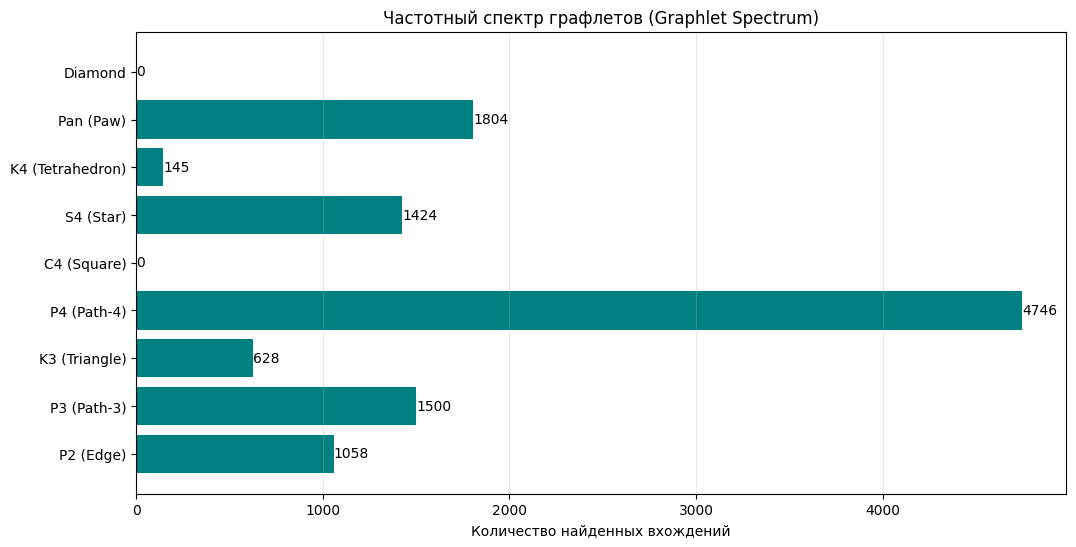

In [ ]:
# --- 4. Визуализация статистики ---
names = list(graphlet_counts.keys())
counts = list(graphlet_counts.values())

plt.figure(figsize=(12, 6))
bars = plt.barh(names, counts, color='teal')
plt.xlabel('Количество найденных вхождений')
plt.title('Частотный спектр графлетов (Graphlet Spectrum)')
plt.grid(axis='x', alpha=0.3)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2, 
             f'{int(width)}', va='center')

plt.show()